In [1]:
""" 
直接拿3.BP去改

知识预告：
    - 框架封装的理解
    - 熟练使用debug来理解复杂程序
 """

# 数据加载和预处理
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
import pandas as pd 
import math
import pickle as pkl

#-------------------------------------------------- 工具函数 ------------------------------------------------------
#region
def one_func_set_all_random_seed(seed=0):
    # different random seeds
    import torch
    torch.manual_seed(seed)

    import random
    random.seed(seed)

    import numpy as np
    np.random.seed(seed)

    torch.use_deterministic_algorithms(True)

    # for dataloader
    g = torch.Generator()
    g.manual_seed(seed)

    return g

_ = one_func_set_all_random_seed()

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    ez = np.exp(z)
    return ez / ez.sum(axis=1, keepdims=True)


def load_labels(file):
    '''
    解码标签文件
    '''
    with open(file, "rb") as f:
        data = f.read()  # kp: 任务整理 readlines  readline  and read 的区别
    
    magic_number, num_samples = struct.unpack(">ii", data[:8])  # refer to magic_number.jpg  # struct.unpack refer to https://docs.python.org/3/library/struct.html
                                                                # >ii refer to https://docs.python.org/3/library/struct.html
    if magic_number != 2049:
        print(f"magic number mismatch {magic_number} != 2049")
        return None

    labels = np.array(list(data[8:])) # np.asarray  
    return labels

def load_images(file):
    with open(file, "rb") as f: # note rb or r
        data = f.read()
    
    magic_number, num_samples, image_height, image_width = struct.unpack(">iiii", data[:16])

    if magic_number != 2051:
        print(f"magic number mismatch {magic_number} != 2051")
        return None
    
    image_data = np.array(list(data[16:]), dtype=np.uint8).reshape(num_samples, -1) # dtype = "uint8"

    return image_data


def one_hot(labels, classes):
    n = len(labels)
    output = np.zeros((n, classes), dtype = np.int32)
    for row, label in enumerate(labels):
        output[row, label] = 1
    return output

def show_hist(labels, num_classes): # 常用的小工具函数的写法
    label_map = {key: 0 for key in range(num_classes)} # 给每一个类都初始化： 数量为0
    for label in labels:       # 循环labels，遇到label x  就去label x的keyvalue对里+1
        label_map[label] += 1  # 这里相当于是一个一个label item去算
    
    # label_hist 是一个list, list 的值是 label_map key-value 对儿里的 value
    labels_hist = [label_map[key] for key in range(num_classes)]  
    pd.DataFrame(labels_hist, columns=["label"]).plot(kind = "bar") # api 用法的形象记忆 refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
                                                                    # refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

    evaluate(test_loader, W, b1, U, b2)
    evaluate(test_loader, W, b1, U, b2)
    evaluate(test_loader, W, b1, U, b2)

    evaluate(test_loader, W, b1, U, b2)

def evaluate(test_loader,model, epoch = None, loss = None):
    model.eval()

    correct = 0
    for test_images, test_labels, _ in test_loader:
        probability = softmax(model.inference(test_images))
        predict_labels     = probability.argmax(axis=1).reshape(-1, 1)
        correct       += (predict_labels == test_labels).sum()
    
    acc = correct / len(test_dataset)

    if (epoch is not None) and (loss is not None):
        print(f"{epoch}. train_Loss: {loss:.3f}, test_Accuracy: {acc:.5f}") 
    else:
        print(f"test_Accuracy: {acc:.5f}") 


#endregion
#-------------------------------------------------- 工具函数 ------------------------------------------------------


#-------------------------------------------------- 数据集管理 ------------------------------------------------------
#region
# 创建管理数据和数据加载的类
class Dataset:
    # 动态的，那么Dataset是个基类，所有动态的继承自Dataset
    # 需要实现什么接口？
    def __getitem__(self, index):
        raise NotImplementedError()
        
    def __len__(self):
        raise NotImplementedError()

class MNIST_Dataset(Dataset):
    # 针对mnist数据的解析、加载、预处理(e.g. /255), 加一个全是1的维度etc
    def __init__(self, image_file, label_file, *args):
        self.num_classes = 10
        self.images = load_images(image_file)
        self.labels = load_labels(label_file)

        self.images = (self.images / 255.0 -0.5).astype(np.float64) # 64
        self.images = (self.images - 0.130627) / 0.3081
        self.labels_one_hot = one_hot(self.labels, self.num_classes)
        
    def __getitem__(self, index):
        """ 
        角色的职责
        实现图像加载、归一化/标准化、onehot
            为什么要返回one_hot，计算时，使用one_hot比较方便
            为什么要返回label，因为做测试的时候，label比较方便
            pytorch里面，CELoss使用的不是one_hot。所以以后不需要返回one_hot
         """
        return self.images[index], self.labels[index], self.labels_one_hot[index]

    # 获取数据集的长度，个数
    def __len__(self):
        return len(self.images)

class DataLoader:
    """
    职责
    实例化的时候需要指定dataset，batch_size，shuffle
    数据的封装，打包为一个batch
    对数据进行打乱
    可以通过迭代器来获取一批一批的数据
     """
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = dataset
        self.shuffle = shuffle
        self.count_data = len(dataset)
        self.batch_size = batch_size

    def __iter__(self):
        # 实例化一个迭代器对象，将自身作为参数传入进去
        return DataLoaderIterator(self)

    def __len__(self):
        """ 
        用以告诉外界，多少次迭代，就算是完成一轮
        这里有2种处理方法
        1.向上取整
        2.整除，向下取整，多余部分丢弃
        这里考虑用策略2
         """
        return len(self.dataset) // self.batch_size
        
class DataLoaderIterator:
    """ 
    职责：
        对打包好的batch一个一个的输出
     """
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
        # 这里有2中处理策略
        # 1.向上取整
        # 2.整除，向下取整，多余部分丢弃
        # 这里考虑用方法2
        self.num_batch_per_epoch = len(dataloader)
        
        # 定义指针记录当前batch的索引
        self.batch_cursor = 0

        # 实现一轮数据的打乱和封装获取
        # 与其打乱数据，不如打乱索引
        self.indexes = list(range(len(dataloader.dataset)))

        # 如果需要随机打乱，条件控制由dataloader的shuffle决定
        if dataloader.shuffle:
            np.random.shuffle(self.indexes)  # inplace e.g. [0,1,2,3 ....59999] --> [2,1,48,23,...0]
    
    def __next__(self): # 指的是next batch
        # 如果到了一轮的边界，即迭代结束，抛出异常 (一上来就做判断)
        if self.batch_cursor >= self.num_batch_per_epoch:
            # 如果到了边界，抛出StopIteration
            raise StopIteration()
        """ 
        职责：如何一个又一个的数据进行吐出, 每一行是一个数据
            b1  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            b2  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            b3  image.shape = 784,     label.shape = 1,     label_onehot.shape = 10,
            ......
            n 个 data
        
        images.shape = n x 784     labels.shape = n x 1        one_hot.shape = n x 10
         """ 

        batch_data = []
        for i in range(self.dataloader.batch_size): # 遍历一个batch里的图片
            """ 
             拿到图像的索引，这个索引可能是打乱的
              """
            index = self.indexes[self.batch_cursor * self.dataloader.batch_size + i] # 全局idx
            # 从dataset中拿到数据 e.g. 一个数据由图像和标签组成
            data_item = self.dataloader.dataset[index]

            if len(batch_data) == 0:
                batch_data = [[] for _ in data_item] # 这里有3个
            
            # 把data_item中的每一项，分门别类的放到batch_data中
            for index, item in enumerate(data_item):
                batch_data[index].append(item)


        # 遍历完了这个batch里的所有图片，要到下一个batch了
        self.batch_cursor += 1

        # 当整个batch的数据准备好过后，可以用np.vstack拼接在一起
        for index in range(len(batch_data)):
            batch_data[index] = np.vstack(batch_data[index])

        return tuple(batch_data)
#endregion
#-------------------------------------------------- 数据集管理 ------------------------------------------------------


#-------------------------------------------------- 计算流程的管理 ------------------------------------------------------
#region

""" 
思考的时候可以参考下面的流程：
    Parameter
    Module
    Linear
    Sigmoid
    SoftmaxCrossEntropyloss
    Network ---> Sequential
    Optimizer
    SGD

 """


class Module:
    """ 
        1.可以称之为算子，那么他应该有forward、backward。为了简化代码，可以用__call__实现forward
        2.需要实现以个params函数，拿出当前module下的所有【递归，如果有子类里面还有子类包含了参数，也要拿出来】参数实例
        3.考虑有些算子，需要感知当前的环境属于训练还是推理，用 train_mode 储存是否为训练状态提供给特定算子用。通过
        train方法和eval方法修改 train_mode 的值

    """
    def __init__(self):
        self.train_mode = False # 为什么需要呢？一个模块的训练模式可能跟测试模式不一样。比如 模拟考搞点意外

    def forward(self, *args):
        # forward输入参数可以是多个
        raise NotImplementedError() # NotImplementedError : https://blog.csdn.net/grey_csdn/article/details/77074707

    def backward(self, grad):
        # 假设算子输出只有一个，所以对应的梯度也应该只有一个
        raise NotImplementedError()


    def __call__(self, *args):  # __call__ ref: http://c.biancheng.net/view/2380.html  # 不定长参数
        return self.forward(*args)

    def train(self):
        self.train_mode = True
        for m in self.modules(): # 什么意思呢？即 你对任意一个module 开启 train mode 其实是对 它的 sub-module 开启train mode
            m.train()

    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
    
    def modules(self): # 获取一个模块的所有子模块 这里没有递归
        ms = []
        for attr in self.__dict__: # __dict__  ref: 第一部分 重点理解obj.__dict__即可  https://www.cnblogs.com/starrysky77/p/9102344.html
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)

        return ms

    def params(self): # 获取一个模块所有的参数（如果有的话） 这里有递归
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]     
            if isinstance(p, Parameter): # 先看一下这个p是不是Parameter。kp: 这里用到了递归， 这里是递归的边界  不记得的建议去看一下 python 阶乘 递归
                ps.append(p)            
        
        ms = self.modules()             # 如果不是Parameter的话就直接去找它的子模块（如果有的话）     
        for m in ms:         
            ps.extend(m.params())       # 对所有的子模块依次获取所有参数

        return ps                 

    # -----------------小工具方法（非重点）------------------
    def info(self, n):
        ms = self.modules()  # 拿到所有子模块
        name = self.__class__.__name__ # 拿到当前模块的class 名称
        output = f"{name}\n" 
        for m in ms:         # 下面也是递归
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n" # 顶头缩进，接着以同样的方式去打印它的子模块

        return output[:-1]

    def __repr__(self):
        return self.info(0)
        
class Parameter:
    """ 
    实例化的时候，传入参数值
    封装data、和grad，储存参数值和梯度
        grad.shape = forward(x).shape = batch_size x num_output
        bias.shape = 1 x num_output
     """
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data) # del_W 和 W 的形状要是一样大的

    # 清空参数中存储的梯度
    def zero_grad(self):   # 为什么要清空梯度？ ref: https://blog.csdn.net/weixin_42542536/article/details/104725921
        self.grad[...] = 0 # inplace 操作

class Linear(Module):
    """     
    线性算子，线性层
     职责:
     包含了参数（parameter），包含了运算过程（forward、backward），对于输入的梯度计算，
     和对于参数（parameter）的梯度计算

    """
    def __init__(self, num_input, num_output): # 回忆 W  比如: X @ W  = Y   [32x784]@[784x10] = [32x10]
        super().__init__() # 你如果有继承请一定一定一定要写super
        
        # init method
        # 试一下在这里加入or改成kaiming init
        self.weight = Parameter(np.random.normal(0,1, size = (num_input, num_output)))
        self.bias = Parameter(np.zeros((1, num_output)))

    def forward(self, x):
        # 保存x给到backward时使用。 回忆 X @ W = Y    del_W = X^T @ G
        self.x = x

        return x @ self.weight.data + self.bias.data # 回忆一下，加入weight是[784,10] 那么bias形状是多大[10]
    
    def backward(self, grad):
        """ 
        回忆矩阵乘法：
            X @ W = Y
            del_W = X^T @ G
            del_X = G   @ W^T

         """
        self.weight.grad += self.x.T @ grad  # 回忆一下所说的更新部分  # 为什么要写成+=????
        self.bias.grad   += np.sum(grad, axis = 0, keepdims = True)
        
        return grad @ self.weight.data.T  # 和反传部分

class Sigmoid(Module):
    def __init__(self):
        super().__init__()


    def forward(self, z):
        self.out = 1 / (1 + np.exp(-z))
        return self.out

    def backward(self, grad):
        return grad * self.out * (1 - self.out)
    
class SoftmaxCrossEntropyLoss(Module): # 一般的我们会把softmax 跟 loss合起来
    def __init__(self):
        super().__init__()
    
    def forward(self, x, gt):
        self.gt = gt
        ex = np.exp(x)

        # softmax部分
        sum_ex = ex.sum(axis = 1, keepdims = True)
        self.probability = ex / sum_ex
        self.batch_size = x.shape[0]

        # loss 部分
        return -np.sum(self.gt * np.log(self.probability)) / self.batch_size

    def backward(self, grad = 1):
        return grad * (self.probability - self.gt) / self.batch_size

class Sequential(Module):
    def __init__(self, *items): # 初始化的时候放入一些模块
        super().__init__()
        self.items = items

    def modules(self): # 只是返回最浅层即可
        """ 
        覆盖基类的modules方法，直接返回items即可
         """
        return self.items
    
    def forward(self, x):
        # 按照顺序执行items即可
        for m in self.items:
            x = m(x)
        return x

    def backward(self, grad):
        # 按照反向顺序，执行items中模块的backward
        for item in self.items[::-1]: # kp：逆序
            grad = item.backward(grad)
            
        return grad

class Model(Module):
    def __init__(self, num_feature, num_hidden, num_classes): # 可以把Network理解成一个大矩阵。这里num_input就是num_feature 784
        super().__init__()

        self.layers = Sequential(
            Linear(num_feature, num_hidden),
            Sigmoid(),
            Linear(num_hidden, num_classes)
        )

        self.loss = SoftmaxCrossEntropyLoss()


    def inference(self, x):
        return self.layers(x)

    def forward(self, x, gt):
        # forward 和 inference 的不同，前者在训练的时候要算loss
        return self.loss(self.inference(x), gt)

    def backward(self, grad = 1):
        grad = self.loss.backward(grad)
        return self.layers.backward(grad)

    def save(self, f):
        param_list = []
        for p in self.params():
            data = p.data
            grad = p.grad
            param_list.append((data,grad))


        pkl.dump(param_list,open(f"{f}","wb"))
        print(f"the model has been saved.")
        
            
    def load(self, f):
        param_list = pkl.load(open(f"{f}","rb"))
        param_module_list = self.params()

        for idx ,p in enumerate(param_list): # 
            param_module_list[idx].data = p[0] # e.g. (784, 512) 
            param_module_list[idx].grad = p[1] # e.g. (784, 512)

            
        


class Optimizer:
    def __init__(self, params, lr = 0.1):
        # 给我所有的params，我给你做更新和应用
        self.params = params # ps = []
        self.lr = lr

    def step(sefl):
        raise NotImplementedError()

    def zeros_grad(self):
        # 清空所有参数中的梯度
        # 如果需要累计梯度，可以自行控制
        for param in self.params:
            param.zero_grad() # 调用的是class Parameter 的 zero_grad()
        
    def set_lr(self, lr):
        self.lr = lr

class SGD(Optimizer):
    def __init__(self, params, lr):
        super().__init__(params, lr = lr)
    
    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad

#endregion
#-------------------------------------------------- 计算流程的管理 ------------------------------------------------------


train_labels = load_labels("dataset/train-labels-idx1-ubyte")
train_images = load_images("dataset/train-images-idx3-ubyte")
train_numdata = train_labels.shape[0] # 60000

val_labels = load_labels("dataset/t10k-labels-idx1-ubyte") # 10000
val_images = load_images("dataset/t10k-images-idx3-ubyte") # 10000, 784


- How to Transform Data to Better Fit The Normal Distribution
- https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/

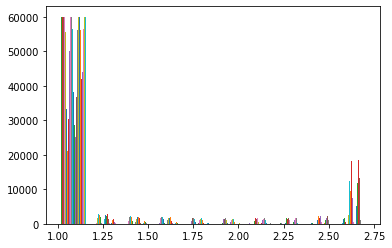

In [18]:
from numpy import exp
from matplotlib import pyplot
# seed the random number generator
# generate two sets of univariate observations
# transform to be exponential

data = np.exp(train_images / 255.0)
pyplot.hist(data)
pyplot.show()

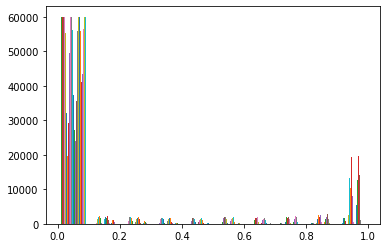

In [19]:
pyplot.hist(train_images / 255.0)
pyplot.show()




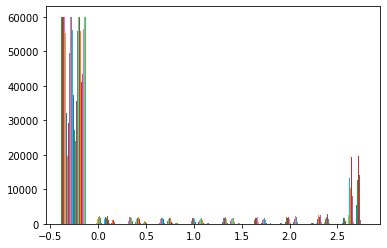

In [20]:
pyplot.hist((train_images - 33.31002) / 78.567489)
pyplot.show()

In [ ]:


#-------------------------------------------------- 训练主干 ------------------------------------------------------
#region
#----------------------- 各种初始化 和 预处理 ------------------------
# 重要超参
num_train_images = train_images.shape[0]
num_feature = train_images.shape[1]
num_hidden = 512
num_classes = 10
batch_size = 32
lr = 0.1
num_epochs = 10

# 加载数据
train_dataset = MNIST_Dataset("dataset/train-images-idx3-ubyte", "dataset/train-labels-idx1-ubyte")
train_loader  = DataLoader(train_dataset, batch_size, True)
test_dataset = MNIST_Dataset("dataset/t10k-images-idx3-ubyte", "dataset/t10k-labels-idx1-ubyte")
test_loader  = DataLoader(test_dataset, 500, False)

# 定义网络结构
model = Model(num_feature, num_hidden, num_classes)
optim = SGD(model.params(), lr) # ??? network.params()为什么可以用

#----------------------- TRAIN ------------------------
print(f"start training: \nlr:{lr}  batchsize {batch_size}  num_hidden: {num_hidden}  epochs: {num_epochs}")

for epoch in range(num_epochs):
    model.train()
    for images, labels, onehot_labels in train_loader:
        
        loss = model(images, onehot_labels)

        optim.zeros_grad()
        model.backward()
        optim.step()

    evaluate(test_loader, model, epoch, loss)

# model.save("latest_model.pkl")
#endregion
#-------------------------------------------------- 训练主干 ------------------------------------------------------

# 读取预训练模型
# model.load("latest_model.pkl")
# evaluate(test_loader, model)

